In [225]:
import numpy as np
import pandas as pd
import os
from datetime import datetime,timedelta
import math
import matplotlib.pyplot as plt
import seaborn  

In [244]:
from_str='2022-01-01'
to_str='2023-01-31'
feq ='M'  # support month=M,quater=Q,year=Y
title=f"SMALL-THAI-{feq}"



#data_file=data_path=r"D:\PythonDev\MyQuantFinProject\Data\TiscoThai_y20t22.csv"
data_file=data_path=r"D:\PythonDev\MyQuantFinProject\Data\THAI-SMALL_Y20ToNow.csv"

# Build Asset Timeseries

In [245]:
period_index=pd.date_range(start=from_str,end=to_str, freq=feq)
print(period_index)

# create StartDate as Nan
fundPerfByPeriod_df=pd.DataFrame(index=period_index,columns=['Start_Date'])

# move index to EndDate column
fundPerfByPeriod_df.reset_index(drop=False,inplace=True)

# change columns  index,Start_Date =End_Date,Start_Date
fundPerfByPeriod_df.columns=['End_Date','Start_Date']
# change column order
fundPerfByPeriod_df=fundPerfByPeriod_df[['Start_Date','End_Date']]

print(f"Create the first day of {feq} by iteration")
# print(fundPerfByPeriod_df)

for index,row in fundPerfByPeriod_df.iterrows():
    if index==0:
       fundPerfByPeriod_df.iloc[0,0]=datetime.strptime(from_str,'%Y-%m-%d')
    else:
        # get End_Date(last day of Year, Quater,Month) of previouse row 
        prev_end_date= fundPerfByPeriod_df.iloc[index-1,1] 
        start_date=prev_end_date + timedelta(days = 1) # 
        fundPerfByPeriod_df.iloc[index,0]=start_date 
fundPerfByPeriod_df['Start_Date']=pd.to_datetime(fundPerfByPeriod_df['Start_Date'],format='%Y-%m-%d %H:%M:%S')    

fundPerfByPeriod_df['Period']= fundPerfByPeriod_df.apply( lambda item:f"{item['Start_Date'].strftime('%d')}{item['Start_Date'].strftime('%b')}{item['Start_Date'].strftime('%y')}_{item['End_Date'].strftime('%d')}{item['End_Date'].strftime('%b')}{item['End_Date'].strftime('%y')}"  ,axis=1  )
fundPerfByPeriod_df.info()

print(f"Created {feq} Time Series")
fundPerfByPeriod_df



DatetimeIndex(['2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31'],
              dtype='datetime64[ns]', freq='M')
Create the first day of M by iteration
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Start_Date  13 non-null     datetime64[ns]
 1   End_Date    13 non-null     datetime64[ns]
 2   Period      13 non-null     object        
dtypes: datetime64[ns](2), object(1)
memory usage: 440.0+ bytes
Created M Time Series


,Start_Date,End_Date,Period
0,2022-01-01,2022-01-31,01Jan22_31Jan22
1,2022-02-01,2022-02-28,01Feb22_28Feb22
2,2022-03-01,2022-03-31,01Mar22_31Mar22
3,2022-04-01,2022-04-30,01Apr22_30Apr22
4,2022-05-01,2022-05-31,01May22_31May22
5,2022-06-01,2022-06-30,01Jun22_30Jun22
6,2022-07-01,2022-07-31,01Jul22_31Jul22
7,2022-08-01,2022-08-31,01Aug22_31Aug22
8,2022-09-01,2022-09-30,01Sep22_30Sep22
9,2022-10-01,2022-10-31,01Oct22_31Oct22


# Load data and Transform

In [246]:
# source file : Ticker,Date/Time,open,high,low,close,Volume
df = pd.read_csv(data_file,index_col='Date/Time',parse_dates=['Date/Time'],dayfirst=True)

df.index.set_names('date',inplace=True)
df.rename(columns={'Ticker':'symbol','close':'price'},inplace=True)

df=df[['symbol','price']]
df.info()
print(df.tail(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7495 entries, 2022-02-28 to 2023-02-02
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  7495 non-null   object 
 1   price   7495 non-null   float64
dtypes: float64(1), object(1)
memory usage: 175.7+ KB
               symbol  price
date                        
2023-01-20  TISCOMS-A  21.24
2023-01-23  TISCOMS-A  21.26
2023-01-24  TISCOMS-A  21.28
2023-01-25  TISCOMS-A  21.18
2023-01-26  TISCOMS-A  20.92
2023-01-27  TISCOMS-A  21.12
2023-01-30  TISCOMS-A  21.18
2023-01-31  TISCOMS-A  21.21
2023-02-01  TISCOMS-A  21.42
2023-02-02  TISCOMS-A  21.55


# Group Data by Symbol and store in dictionary

In [247]:
list_fund_name=df['symbol'].unique().tolist()  
list_fund_name=['KKP-TQG', 'KKP-SM-CAP', 'KFTHAISM', 'K-MIDSMALL', 'TISCOMS-A']
print(list_fund_name)

['KKP-TQG', 'KKP-SM-CAP', 'KFTHAISM', 'K-MIDSMALL', 'TISCOMS-A']


In [248]:
dictPriceOfFund={}
# key is symbol
# store price dataframe as value in dictionary

for name in list_fund_name:

  fund_df=df.query('symbol==@name')   # https://sparkbyexamples.com/pandas/pandas-dataframe-query-examples/
  fund_df=fund_df.loc[from_str:to_str,['price']]   #https://www.geeksforgeeks.org/python-pandas-dataframe-loc/
  fund_df.sort_index(inplace=True)    #https://www.geeksforgeeks.org/python-pandas-dataframe-sort_index/
  if len(fund_df)  >0:
      # price/symbol
      dictPriceOfFund[name]=fund_df
      print(f"======={name} : {len(fund_df)}==========")  
      print(fund_df.tail(3))   

=======KKP-TQG : 224==========
            price
date             
2023-01-27   8.91
2023-01-30   8.94
2023-01-31   8.97
=======KKP-SM-CAP : 256==========
            price
date             
2023-01-27  17.21
2023-01-30  17.19
2023-01-31  17.15
=======KFTHAISM : 262==========
            price
date             
2023-01-27  14.40
2023-01-30  14.36
2023-01-31  14.38
=======K-MIDSMALL : 262==========
            price
date             
2023-01-27  17.90
2023-01-30  18.00
2023-01-31  17.98
=======TISCOMS-A : 262==========
            price
date             
2023-01-27  21.12
2023-01-30  21.18
2023-01-31  21.21


# Create directory to store chart and excel

In [249]:
report_path="D:\PythonDev\MyQuantFinProject\Data\Report"
report_path=os.path.join (report_path, f"{title}-{feq}-{from_str}_{to_str}")
if not os.path.exists(report_path):
 os.makedirs(report_path)

# Plot Line Chart to compare price movement

In [250]:
# calculate percent change (current-prev)/prev*100  and cumulative return 
def create_pct_acc_df(df_temp,start_pct,end_pct):
    
 df_temp=fund_df.loc[start_pct:end_pct,:]
 df_temp=df_temp.pct_change()  
 df_temp=(1+df_temp).cumprod()  #1 is starting point
 df_temp=df_temp.rename(columns={'price':'cum_return_pct'})
 df_temp.fillna(1,inplace=True)

 return df_temp 

plot chart line to compare return performace entire period
plot chart line to compare return performace on each period


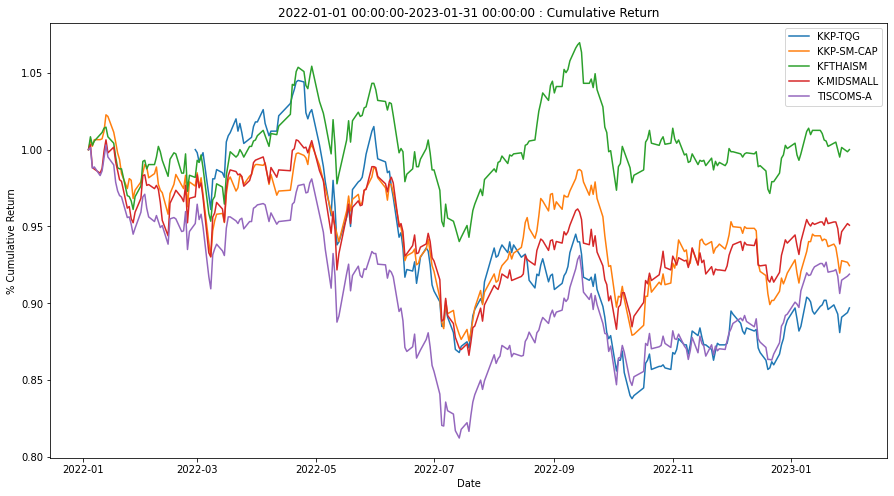

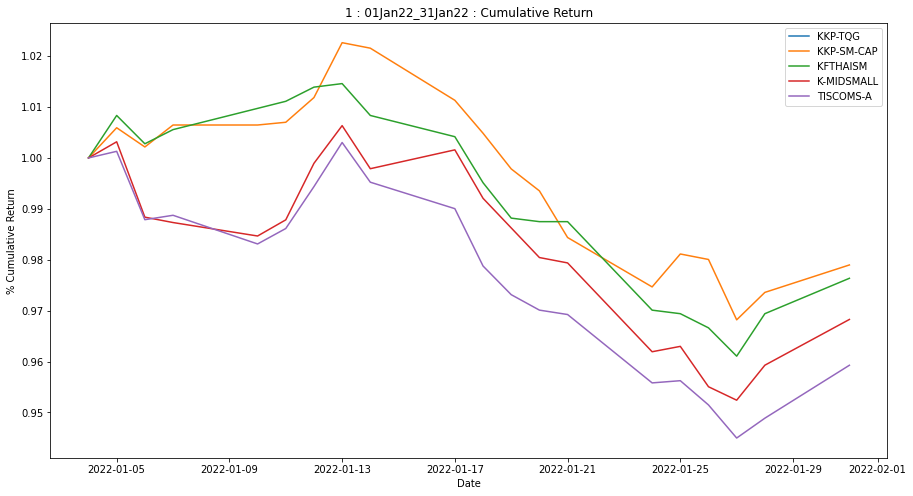

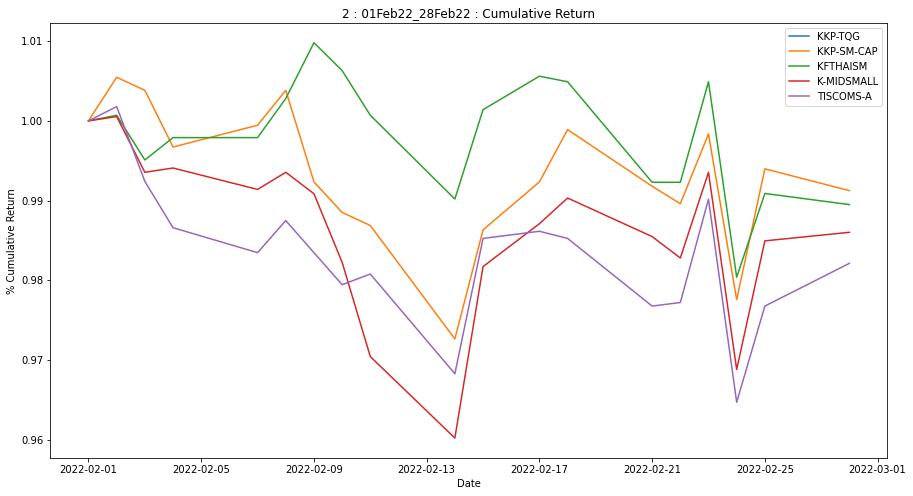

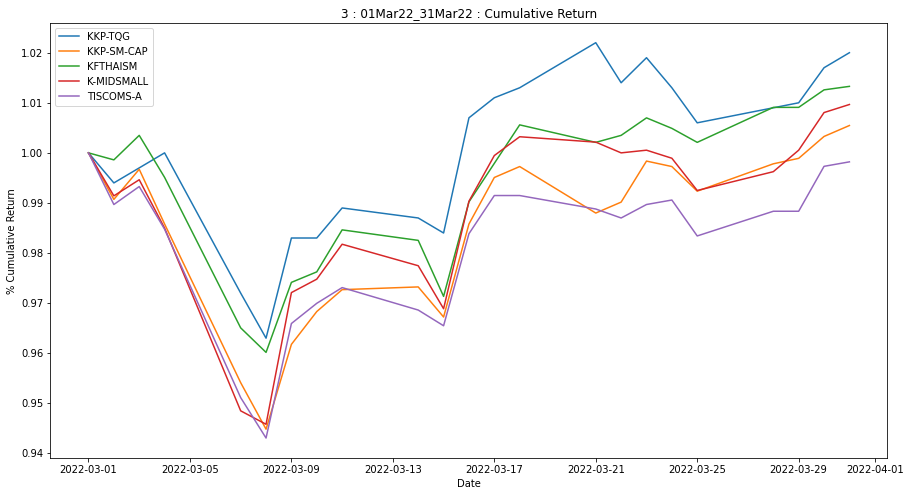

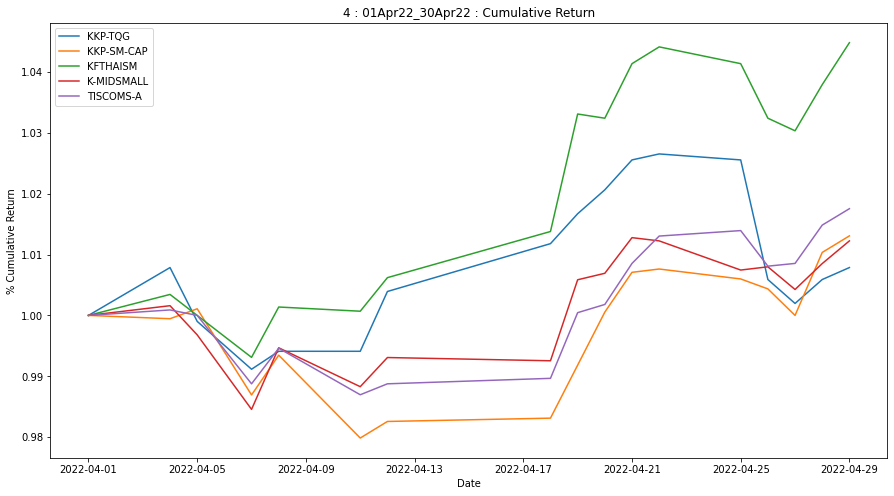

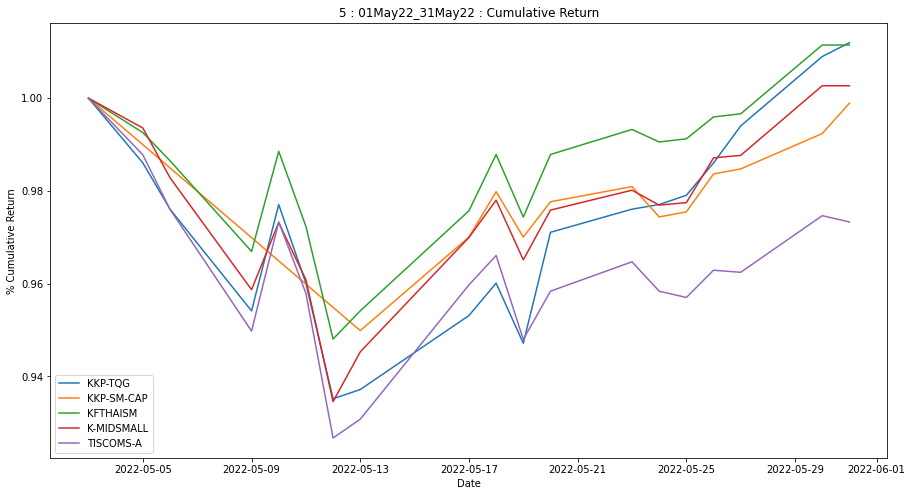

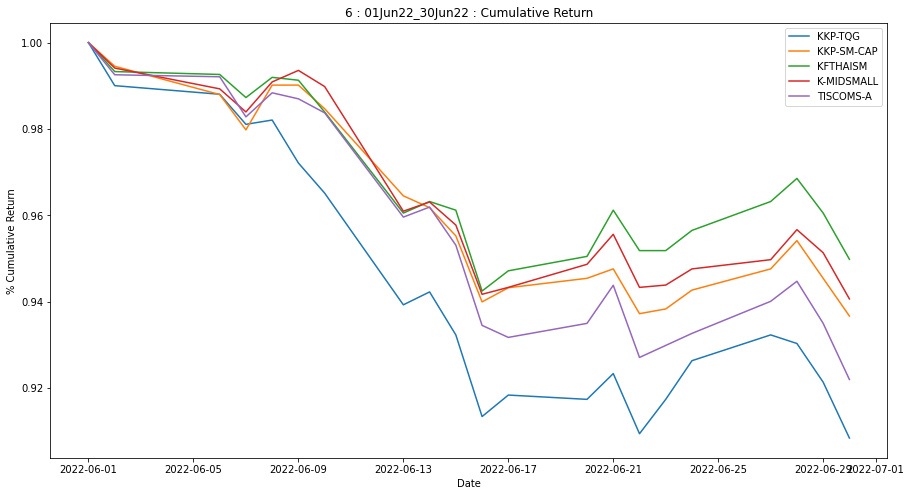

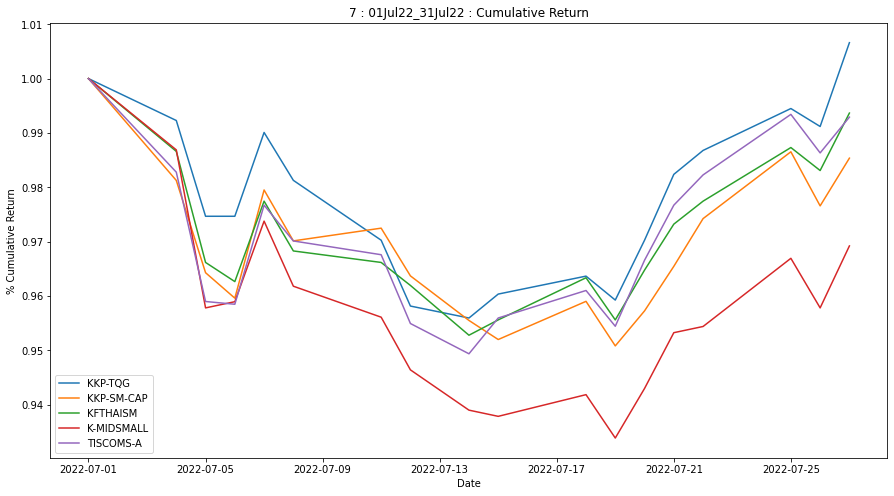

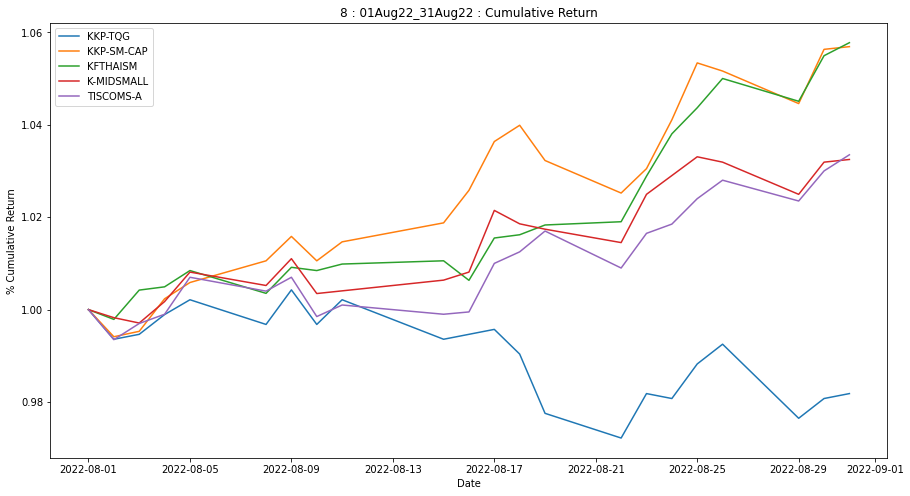

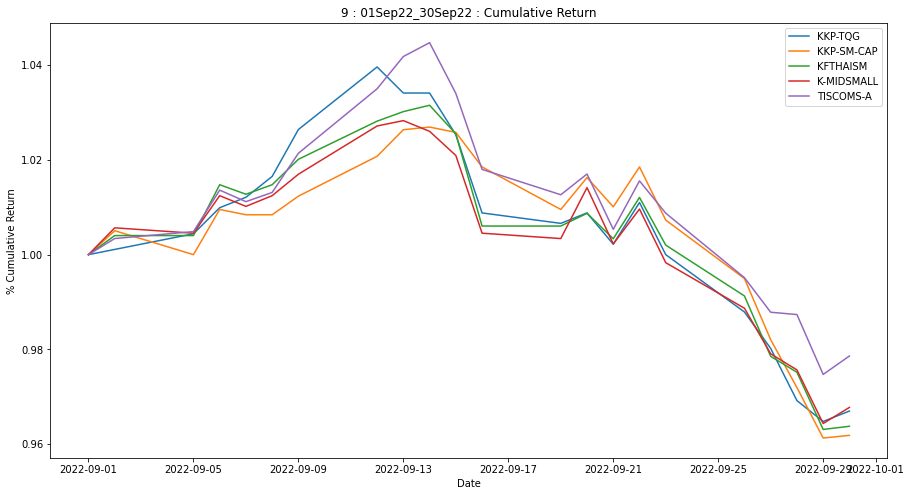

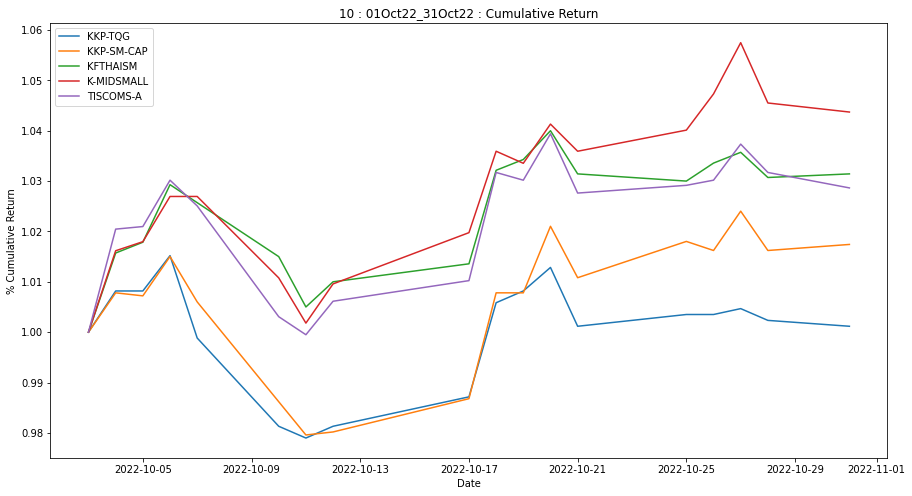

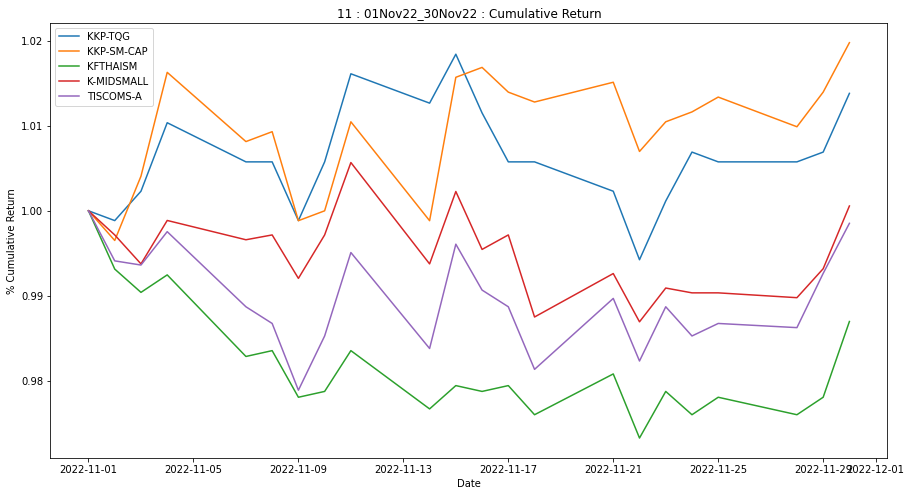

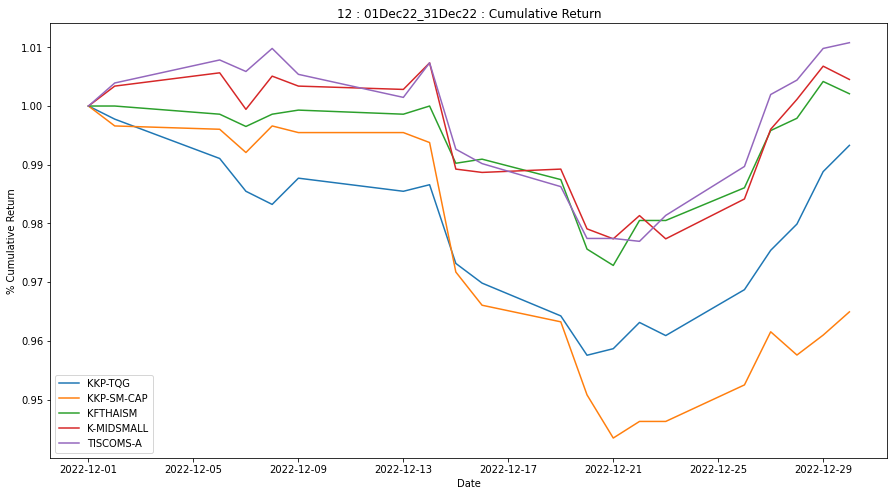

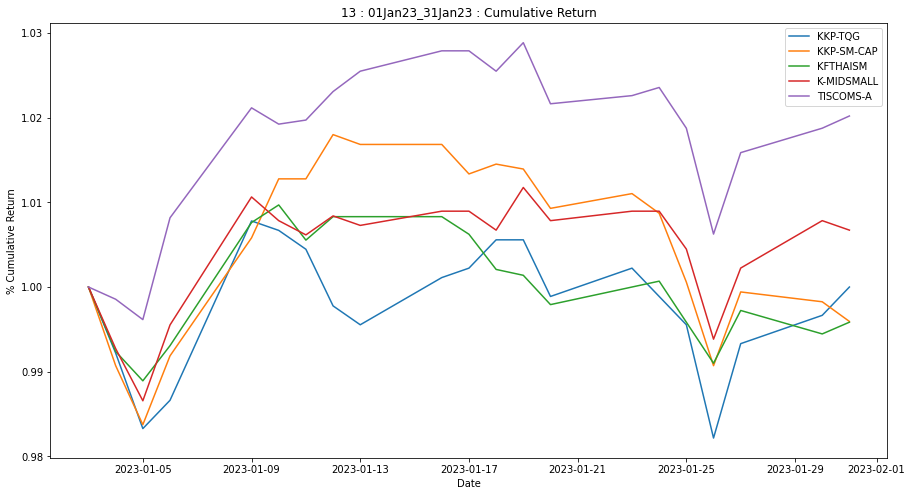

In [251]:
print("plot chart line to compare return performace entire period")
start_date=fundPerfByPeriod_df.loc[0,'Start_Date']
end_date=fundPerfByPeriod_df.loc[len(fundPerfByPeriod_df)-1,'End_Date']

fig = plt.figure(figsize = (15, 8))
for fund_name,fund_df in dictPriceOfFund.items():
  df=create_pct_acc_df(fund_df,start_date,end_date)  
  #print(df.head())
  plt.plot(df.index,df['cum_return_pct'],label =fund_name)  
plt.legend() 
plt.xlabel("Date")
plt.ylabel("% Cumulative Return")

count_pic=count_pic+1
plt.title(f"{start_date}-{end_date} : Cumulative Return")
plt.savefig(f'{report_path}\\All Movement.png')

print("plot chart line to compare return performace on each period")
count_pic=0
for index,item in fundPerfByPeriod_df.iterrows():
    
    start_date=item['Start_Date']
    end_date=item['End_Date'] 
    # print(start_date)
    fig = plt.figure(figsize = (15, 8))
    for fund_name,fund_df in dictPriceOfFund.items():
      df=create_pct_acc_df(fund_df,start_date,end_date)  
      #print(df.head())
      plt.plot(df.index,df['cum_return_pct'],label =fund_name)  
    plt.legend() 
    plt.xlabel("Date")
    plt.ylabel("% Cumulative Return")
    
    count_pic=count_pic+1
    plt.title(f"{count_pic} : {item['Period']} : Cumulative Return")
    #plt.savefig(f'{report_path}\\{count_pic}-{item["Period"]}.png')
    
    plt.show()

# Find Percent of Change (ROC) and  Statistic description

In [252]:
def cal_percent_return(item,fundTemp_df):
    
    start_date=item['Start_Date']
    end_date=item['End_Date']
    
    # filter by date to find ROC of price column during the period
    tempDF=fundTemp_df.loc[start_date:end_date,:]
    if tempDF.empty==False:

        start_price=float(tempDF.iloc[0, 0])  # the first record of fund during the given period (timeframe)
        end_price=float(tempDF.iloc[len(tempDF)-1, 0]) # the last record of fund during the given period (timeframe)

        invest_return =(end_price-start_price)/start_price*100
        invest_return=round(invest_return,1)    

        print(f"{start_date.strftime('%d%b%y')} to {end_date.strftime('%d%b%y')}: ROC = ({end_price}-{start_price})/{start_price}x100= {invest_return} %")

        return invest_return
    else:
        return 0

print("Add column by each ROC of symbol")
for name,data in dictPriceOfFund.items():

  print(f"=========================={name} - cal_percent_return==================================================")
  fundPerfByPeriod_df[name]=fundPerfByPeriod_df.apply(cal_percent_return,axis=1,args=(data,))
  print("***********************************************************************************************")

fundPerfByPeriod_df["_AVG_"]=fundPerfByPeriod_df[list_fund_name].mean(axis=1,skipna=True).round(1)




Add column by each ROC of symbol
==========================KKP-TQG - cal_percent_return==================================================
01Feb22 to 28Feb22: ROC = (10.0-10.0)/10.0x100= 0.0 %
01Mar22 to 31Mar22: ROC = (10.18-9.98)/9.98x100= 2.0 %
01Apr22 to 30Apr22: ROC = (10.26-10.18)/10.18x100= 0.8 %
01May22 to 31May22: ROC = (10.15-10.03)/10.03x100= 1.2 %
01Jun22 to 30Jun22: ROC = (9.12-10.04)/10.04x100= -9.2 %
01Jul22 to 31Jul22: ROC = (9.14-9.08)/9.08x100= 0.7 %
01Aug22 to 31Aug22: ROC = (9.19-9.36)/9.36x100= -1.8 %
01Sep22 to 30Sep22: ROC = (8.79-9.09)/9.09x100= -3.3 %
01Oct22 to 31Oct22: ROC = (8.57-8.56)/8.56x100= 0.1 %
01Nov22 to 30Nov22: ROC = (8.8-8.68)/8.68x100= 1.4 %
01Dec22 to 31Dec22: ROC = (8.89-8.95)/8.95x100= -0.7 %
01Jan23 to 31Jan23: ROC = (8.97-8.97)/8.97x100= 0.0 %
***********************************************************************************************
==========================KKP-SM-CAP - cal_percent_return=================================================

# Compare each fund to avg between peers

In [253]:
def comapre_to_avg(row,fund_name):
    if row[fund_name]>row['_AVG_']:
        return 1
    else:
        return 0
fundRefAvgScore_df=fundPerfByPeriod_df[['Period']]
# for index,item in fundPerfByPeriod_df.iterrows():
for fund_name in list_fund_name:
    fundRefAvgScore_df[fund_name]=fundPerfByPeriod_df.apply(comapre_to_avg,axis=1,args=(fund_name,))
        

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_6688\2405271518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundRefAvgScore_df[fund_name]=fundPerfByPeriod_df.apply(comapre_to_avg,axis=1,args=(fund_name,))
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_6688\2405271518.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fundRefAvgScore_df[fund_name]=fundPerfByPeriod_df.apply(comapre_to_avg,axis=1,args=(fund_name,))
C:\Users\pongthsa\AppData\Local\Temp\ipykernel_6688\2405271518.py:9: SettingWithCopyWarn

In [254]:
fundPerfByPeriod_df.set_index('Period',inplace=True)   
fundRefAvgScore_df.set_index('Period',inplace=True)   

In [255]:
fundPerfByPeriod_df

,Start_Date,End_Date,KKP-TQG,KKP-SM-CAP,KFTHAISM,K-MIDSMALL,TISCOMS-A,_AVG_
Period,,,,,,,,
01Jan22_31Jan22,2022-01-01,2022-01-31,0.0,-2.1,-2.4,-3.2,-4.1,-2.4
01Feb22_28Feb22,2022-02-01,2022-02-28,0.0,-0.9,-1.1,-1.4,-1.8,-1.0
01Mar22_31Mar22,2022-03-01,2022-03-31,2.0,0.5,1.3,1.0,-0.2,0.9
01Apr22_30Apr22,2022-04-01,2022-04-30,0.8,1.3,4.5,1.2,1.8,1.9
01May22_31May22,2022-05-01,2022-05-31,1.2,-0.1,1.1,0.3,-2.7,-0.0
01Jun22_30Jun22,2022-06-01,2022-06-30,-9.2,-6.3,-5.0,-5.9,-7.8,-6.8
01Jul22_31Jul22,2022-07-01,2022-07-31,0.7,-1.5,-0.6,-3.1,-0.7,-1.0
01Aug22_31Aug22,2022-08-01,2022-08-31,-1.8,5.7,5.8,3.2,3.4,3.3
01Sep22_30Sep22,2022-09-01,2022-09-30,-3.3,-3.8,-3.6,-3.2,-2.1,-3.2


# Summary total return and the number of time to beat the average return

In [263]:
dfSummary=pd.concat([fundPerfByPeriod_df[list_fund_name+['_AVG_']].sum().to_frame(name='total_return'),fundRefAvgScore_df.sum().to_frame(name='no_win_avg')],axis=1)
dfSummary.fillna(value=0,inplace=True)
dfSummary


,total_return,no_win_avg
KKP-TQG,-8.8,6.0
KKP-SM-CAP,-7.4,5.0
KFTHAISM,1.6,8.0
K-MIDSMALL,-5.4,6.0
TISCOMS-A,-8.3,6.0
_AVG_,-5.6,0.0


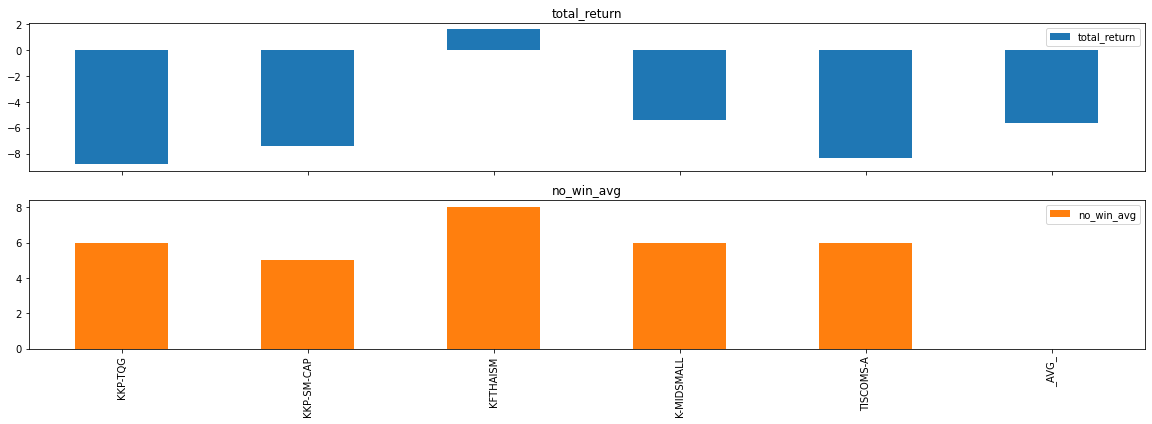

In [264]:
colToPlots=dfSummary.columns

dfSummary.plot(kind='bar',layout=(len(colToPlots),1),
                      subplots=True,figsize=(20, 3*len(colToPlots)))
   
plt.show()


# Find Statistical Description

In [265]:
statDesc_df=fundPerfByPeriod_df[list_fund_name].describe()
# statDesc_df =statDesc_df.T
# statDesc_df=statDesc_df.loc[:]   
statDesc_df.loc[['mean','50%', 'std','max','min'],:]

,KKP-TQG,KKP-SM-CAP,KFTHAISM,K-MIDSMALL,TISCOMS-A
mean,-0.676923,-0.569231,0.123077,-0.415385,-0.638462
50%,0.000000,-0.400000,-0.400000,0.300000,-0.200000
std,2.913232,3.043130,3.073856,2.850394,3.112485
max,2.000000,5.700000,5.800000,4.400000,3.400000
min,-9.200000,-6.300000,-5.000000,-5.900000,-7.800000


# Plot Bar Perfoamce

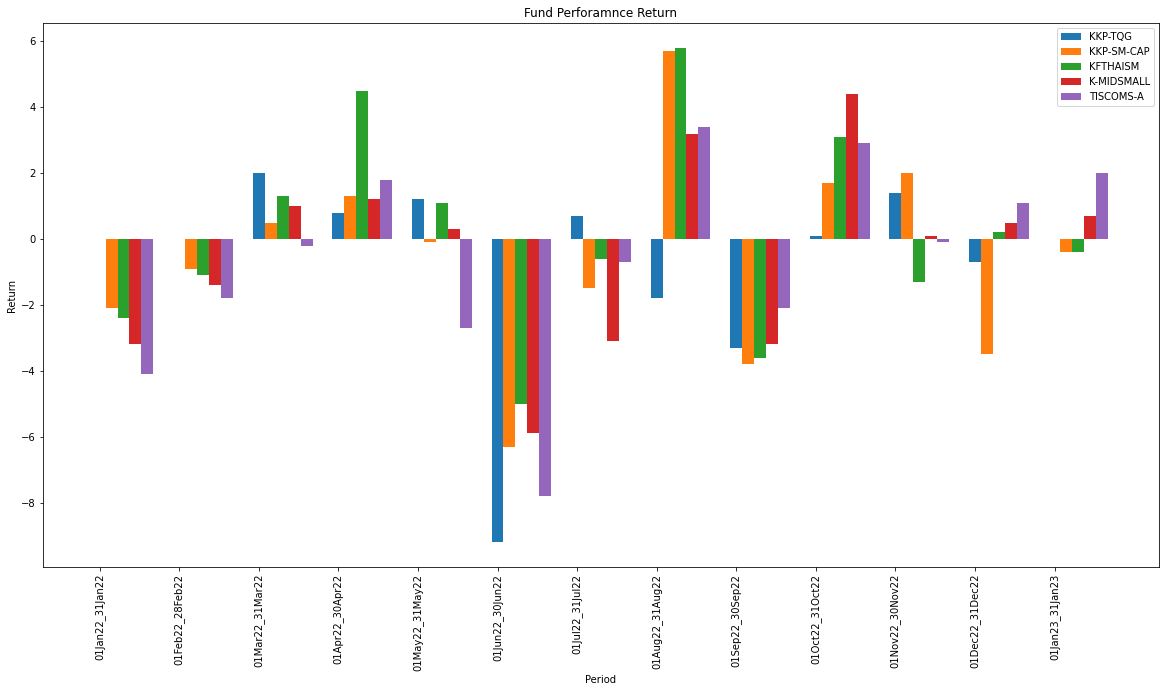

,KKP-TQG,KKP-SM-CAP,KFTHAISM,K-MIDSMALL,TISCOMS-A
Period,,,,,
01Jan22_31Jan22,0.0,-2.1,-2.4,-3.2,-4.1
01Feb22_28Feb22,0.0,-0.9,-1.1,-1.4,-1.8
01Mar22_31Mar22,2.0,0.5,1.3,1.0,-0.2
01Apr22_30Apr22,0.8,1.3,4.5,1.2,1.8
01May22_31May22,1.2,-0.1,1.1,0.3,-2.7
01Jun22_30Jun22,-9.2,-6.3,-5.0,-5.9,-7.8
01Jul22_31Jul22,0.7,-1.5,-0.6,-3.1,-0.7
01Aug22_31Aug22,-1.8,5.7,5.8,3.2,3.4
01Sep22_30Sep22,-3.3,-3.8,-3.6,-3.2,-2.1


In [266]:
fundReturn_df=fundPerfByPeriod_df[list_fund_name]
fig = plt.figure(figsize = (20, 10))
X_axis = np.arange(len(fundReturn_df)) # length of column to fix axis=y
X_point=0.00
X_width=0.15

for colName  in fundReturn_df.columns:
    
    plt.bar(X_axis+X_point,fundReturn_df[colName],X_width, label =colName)
    X_point+=X_width

# length of column to fix axis=y
plt.xticks(X_axis, fundReturn_df.index,rotation='vertical')
plt.xlabel("Period")
plt.ylabel("Return")
plt.title(f"Fund Perforamnce Return")
plt.legend()

plt.savefig(f'{report_path}\\Return_{from_str}_{to_str}.png')

plt.show()

fundReturn_df

# Plot correlation

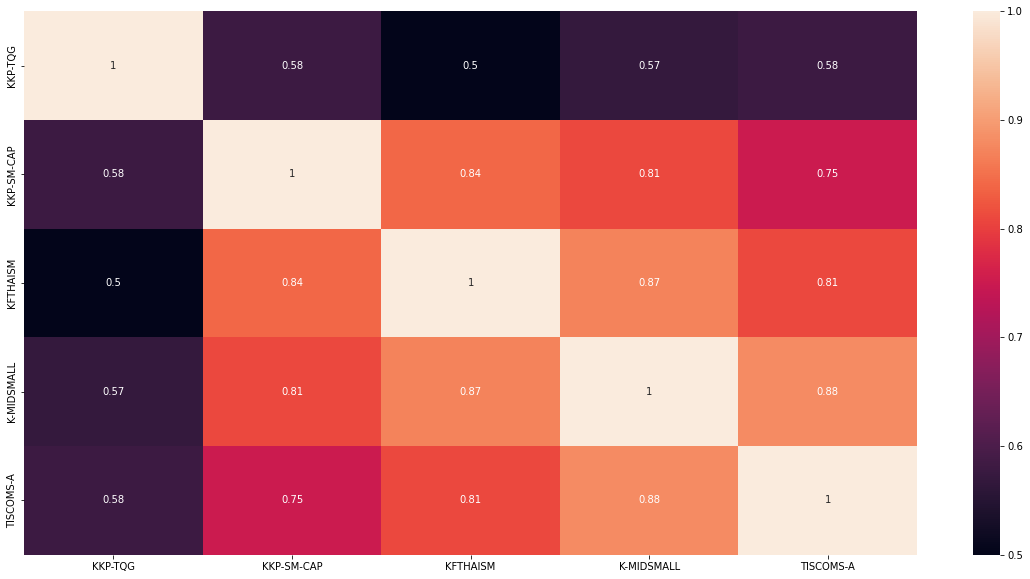

,KKP-TQG,KKP-SM-CAP,KFTHAISM,K-MIDSMALL,TISCOMS-A
KKP-TQG,1.00,0.58,0.50,0.57,0.58
KKP-SM-CAP,0.58,1.00,0.84,0.81,0.75
KFTHAISM,0.50,0.84,1.00,0.87,0.81
K-MIDSMALL,0.57,0.81,0.87,1.00,0.88
TISCOMS-A,0.58,0.75,0.81,0.88,1.00


In [267]:
corr_df = fundReturn_df.corr ()  
corr_df = corr_df .round(2)

fig = plt.figure(figsize = (20, 10))
heatmap = seaborn. heatmap(corr_df, annot = True)  

plt.savefig(f'{report_path}\\Corr_{from_str}_{to_str}.png')
plt. show ()  

corr_df

In [43]:
report_file = os.path .join(report_path, "Report.xlsx")
writer=pd.ExcelWriter(report_file,engine='xlsxwriter') 
fundPerfByPeriod_df.to_excel(writer, sheet_name="Return",index=False)
fundRefAvgScore_df.to_excel(writer, sheet_name="CompareAVG",index=False)
dfSummary  (writer, sheet_name="Summary",index=False)
statDesc_df.to_excel(writer, sheet_name="Des",index=True)
corr_df.to_excel(writer, sheet_name="Des",index=True)
writer.save()

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_18692\190226499.py:8: FutureWarning: save is not part of the public API, usage can give in unexpected results and will be removed in a future version
  writer.save()
